In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame, concat
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier

In [3]:
triage = pd.read_excel('data/data.xlsx')

# remove all empty rows
triage = triage.dropna(how='all')

# drop Alternate Diagnosis? (y/n), Final Triage 1 (1-4), Confidence 1 (%), Final Triage 2 (1-4), Confidence 2 (%), Highly Unrealistic Case (Y), Highly Uncertain (Y), Profile Severity (1-5)
triage = triage.drop(columns=['Unnamed: 0', 'Alternate Diagnosis? (y/n)', 'Final Triage 1 (1-4)', 'Confidence 1 (%)', 'Final Triage 2 (1-4)', 'Confidence 2 (%)', 'Highly Unrealistic Case (Y)', 'Highly Uncertain (Y)', 'Profile Severity (1-5)'], axis=1)
# reset index
triage = triage.reset_index(drop=True)


triage = triage.drop(triage.columns[triage.columns.get_loc('Exacerbation (Y/N)') + 1:], axis=1)
# drop Vitals Severity (1-5)
triage = triage.drop(columns=['Vitals Severity (1-5)'], axis=1)
# convert all values where it say 'Unknown' to NaN
triage = triage.replace('Unknown', np.nan)

# turn Male into 1 and Female into 0
triage = triage.replace('Male', 1)
triage = triage.replace('Female', 0)

# convert height from Height(ft) and Height(in) to Height(cm)
triage['Height(cm)'] = triage['Height(ft)'] * 30.48 + triage['Height(in)'] * 2.54
# drop Height(ft) and Height(in)
triage = triage.drop(columns=['Height(ft)', 'Height(in)'], axis=1)

# convert weight from Weight(lbs) to Weight(kg)
triage['Weight(kg)'] = triage['Weight (lb)'] * 0.45359237
# drop Weight(lbs)
triage = triage.drop(columns=['Weight (lb)'], axis=1)

# recalculate BMI for metric system
triage['BMI'] = triage['Weight(kg)'] / (triage['Height(cm)'] / 100) ** 2

# convert temperature from Temperature(F) to Temperature(C)
triage['Current Temperature'] = (triage['Current Temperature'] - 32) * 5 / 9


risk_factors = ()
# add all unique values in columns Risk Factor 1-4 to risk_factors, make sure there are no duplicates
for i in range(1, 5):
    risk_factors += tuple(triage['Risk Factor ' + str(i)].unique())
risk_factors = tuple(set(risk_factors))
# remove NaN from risk_factors
risk_factors = tuple(filter(lambda x: x == x, risk_factors))
# create a column for each risk factor in risk_factors
for risk_factor in risk_factors:
    triage[risk_factor] = 0
# set all values in the columns to 1 if the risk factor is present
for i in range(1, 5):
    for risk_factor in risk_factors:
        triage.loc[triage['Risk Factor ' + str(i)] == risk_factor, risk_factor] = 1
# drop Risk Factor 1-4
triage = triage.drop(columns=['Risk Factor ' + str(i) for i in range(1, 5)], axis=1)

medications = ()
# split each value in 'Current Medication' at + and add the medication to the tuple if it is not already in there
for medication in triage['Current Medication']:
    # if the value is not empty
    if medication == medication:
        # split the value at + and add the medication to the tuple if it is not already in there
        for med in str(medication).split('+'):
            if med not in medications:
                medications += (med,)



# create a column for each medication in medications
for medication in medications:
    triage[medication] = 0
# set all values in the columns to 1 if the medication is present
for medication in medications:
    triage.loc[triage['Current Medication'].str.contains(medication, na=False), medication] = 1
# drop Current Medication
triage = triage.drop(columns=['Current Medication'], axis=1)

# turn Baseline Dyspnea (MMRC) into the number that the value contains
triage['Baseline Dyspnea (MMRC)'] = triage['Baseline Dyspnea (MMRC)'].str.extract('(\d+)')
# turn COPD Gold Stage into the number that the value contains
triage['COPD Gold Stage'] = triage['COPD Gold Stage'].str.extract('(\d+)')
# turn Recent Worsening in Symptoms? into categorical values for each unique values
triage['Recent Worsening in Symptoms?'] = triage['Recent Worsening in Symptoms?'].astype('category').cat.codes
# turn % Controller Medication Taken Over Last Week into categorical values for each unique values
triage['% Controller Medication Taken Over Last Week'] = triage['% Controller Medication Taken Over Last Week'].astype('category').cat.codes
# turn Short of Breath? into categorical values for each unique values
triage['Short of Breath?'] = triage['Short of Breath?'].astype('category').cat.codes
# turn Cough? into categorical values for each unique values
triage['Cough?'] = triage['Cough?'].astype('category').cat.codes
# turn Sputum? into categorical values for each unique values
triage['Sputum?'] = triage['Sputum?'].astype('category').cat.codes
# turn Wheezing? into categorical values for each unique values
triage['Wheezing?'] = triage['Wheezing?'].astype('category').cat.codes

# turn Current Dyspnea (MMRC) into the number that the value contains
triage['Current Dyspnea (MMRC)'] = triage['Current Dyspnea (MMRC)'].str.extract('(\d+)')

# turn all values that contain 'No' into 0 and all values that contain 'Yes' into 1
triage = triage.replace('No', 0)
triage = triage.replace('Yes', 1)
triage = triage.replace('Y', 1)
triage = triage.replace('y', 0)
triage = triage.replace('N', 0)

# # print missing values
# print(triage.isnull().sum())

categorical_vars = ['COPD Gold Stage']
# impute using mode
for var in categorical_vars:
    triage[var].fillna(triage[var].mode()[0], inplace=True)



numerical_vars = ['Baseline FEV1', 'Baseline Heart Rate', 'Baseline Pulse Ox', 'Baseline Heart Rate.1', 'Baseline Pulse Ox.1', 'Current Heart Rate', 'Current Pulse Ox', 'Current Temperature', 'Current FEV1 (% Predicted)', 'Baseline FEV1 (% Predicted)']

# impute using median
for var in numerical_vars:
    triage[var].fillna(triage[var].median(), inplace=True)


# scaling
scaler = MinMaxScaler()
target = triage['Exacerbation (Y/N)']
triage = triage.drop(columns=['Exacerbation (Y/N)'], axis=1)
triage = pd.DataFrame(scaler.fit_transform(triage), columns=triage.columns)
triage['Exacerbation (Y/N)'] = target

# target variable
# print(triage['Exacerbation (Y/N)'].value_counts())
# balance using smote
sm = SMOTE(random_state=42)
X = triage.drop(columns=['Exacerbation (Y/N)'], axis=1)
y = triage['Exacerbation (Y/N)']
X, y = sm.fit_resample(X, y)
triage = X
triage['Exacerbation (Y/N)'] = y

# print(triage['Exacerbation (Y/N)'].value_counts())

# export to csv
triage.to_csv('data/triage_preprocessed.csv', index=False, sep=";")

array([[<AxesSubplot: title={'center': 'Gender'}>,
        <AxesSubplot: title={'center': 'Age'}>,
        <AxesSubplot: title={'center': 'BMI'}>,
        <AxesSubplot: title={'center': 'Baseline FEV1'}>,
        <AxesSubplot: title={'center': 'Baseline Heart Rate'}>,
        <AxesSubplot: title={'center': 'Baseline Pulse Ox'}>,
        <AxesSubplot: title={'center': 'Recent Worsening in Symptoms?'}>],
       [<AxesSubplot: title={'center': '% Controller Medication Taken Over Last Week'}>,
        <AxesSubplot: title={'center': 'Short of Breath?'}>,
        <AxesSubplot: title={'center': 'Cough?'}>,
        <AxesSubplot: title={'center': 'Wheezing?'}>,
        <AxesSubplot: title={'center': 'Sputum?'}>,
        <AxesSubplot: title={'center': 'Infection?'}>,
        <AxesSubplot: title={'center': 'Respiratory Symptoms Wake You Up At Night More Than Usual?'}>],
       [<AxesSubplot: title={'center': 'Symptom Severity (1-5)'}>,
        <AxesSubplot: title={'center': 'Baseline Heart Rate.1

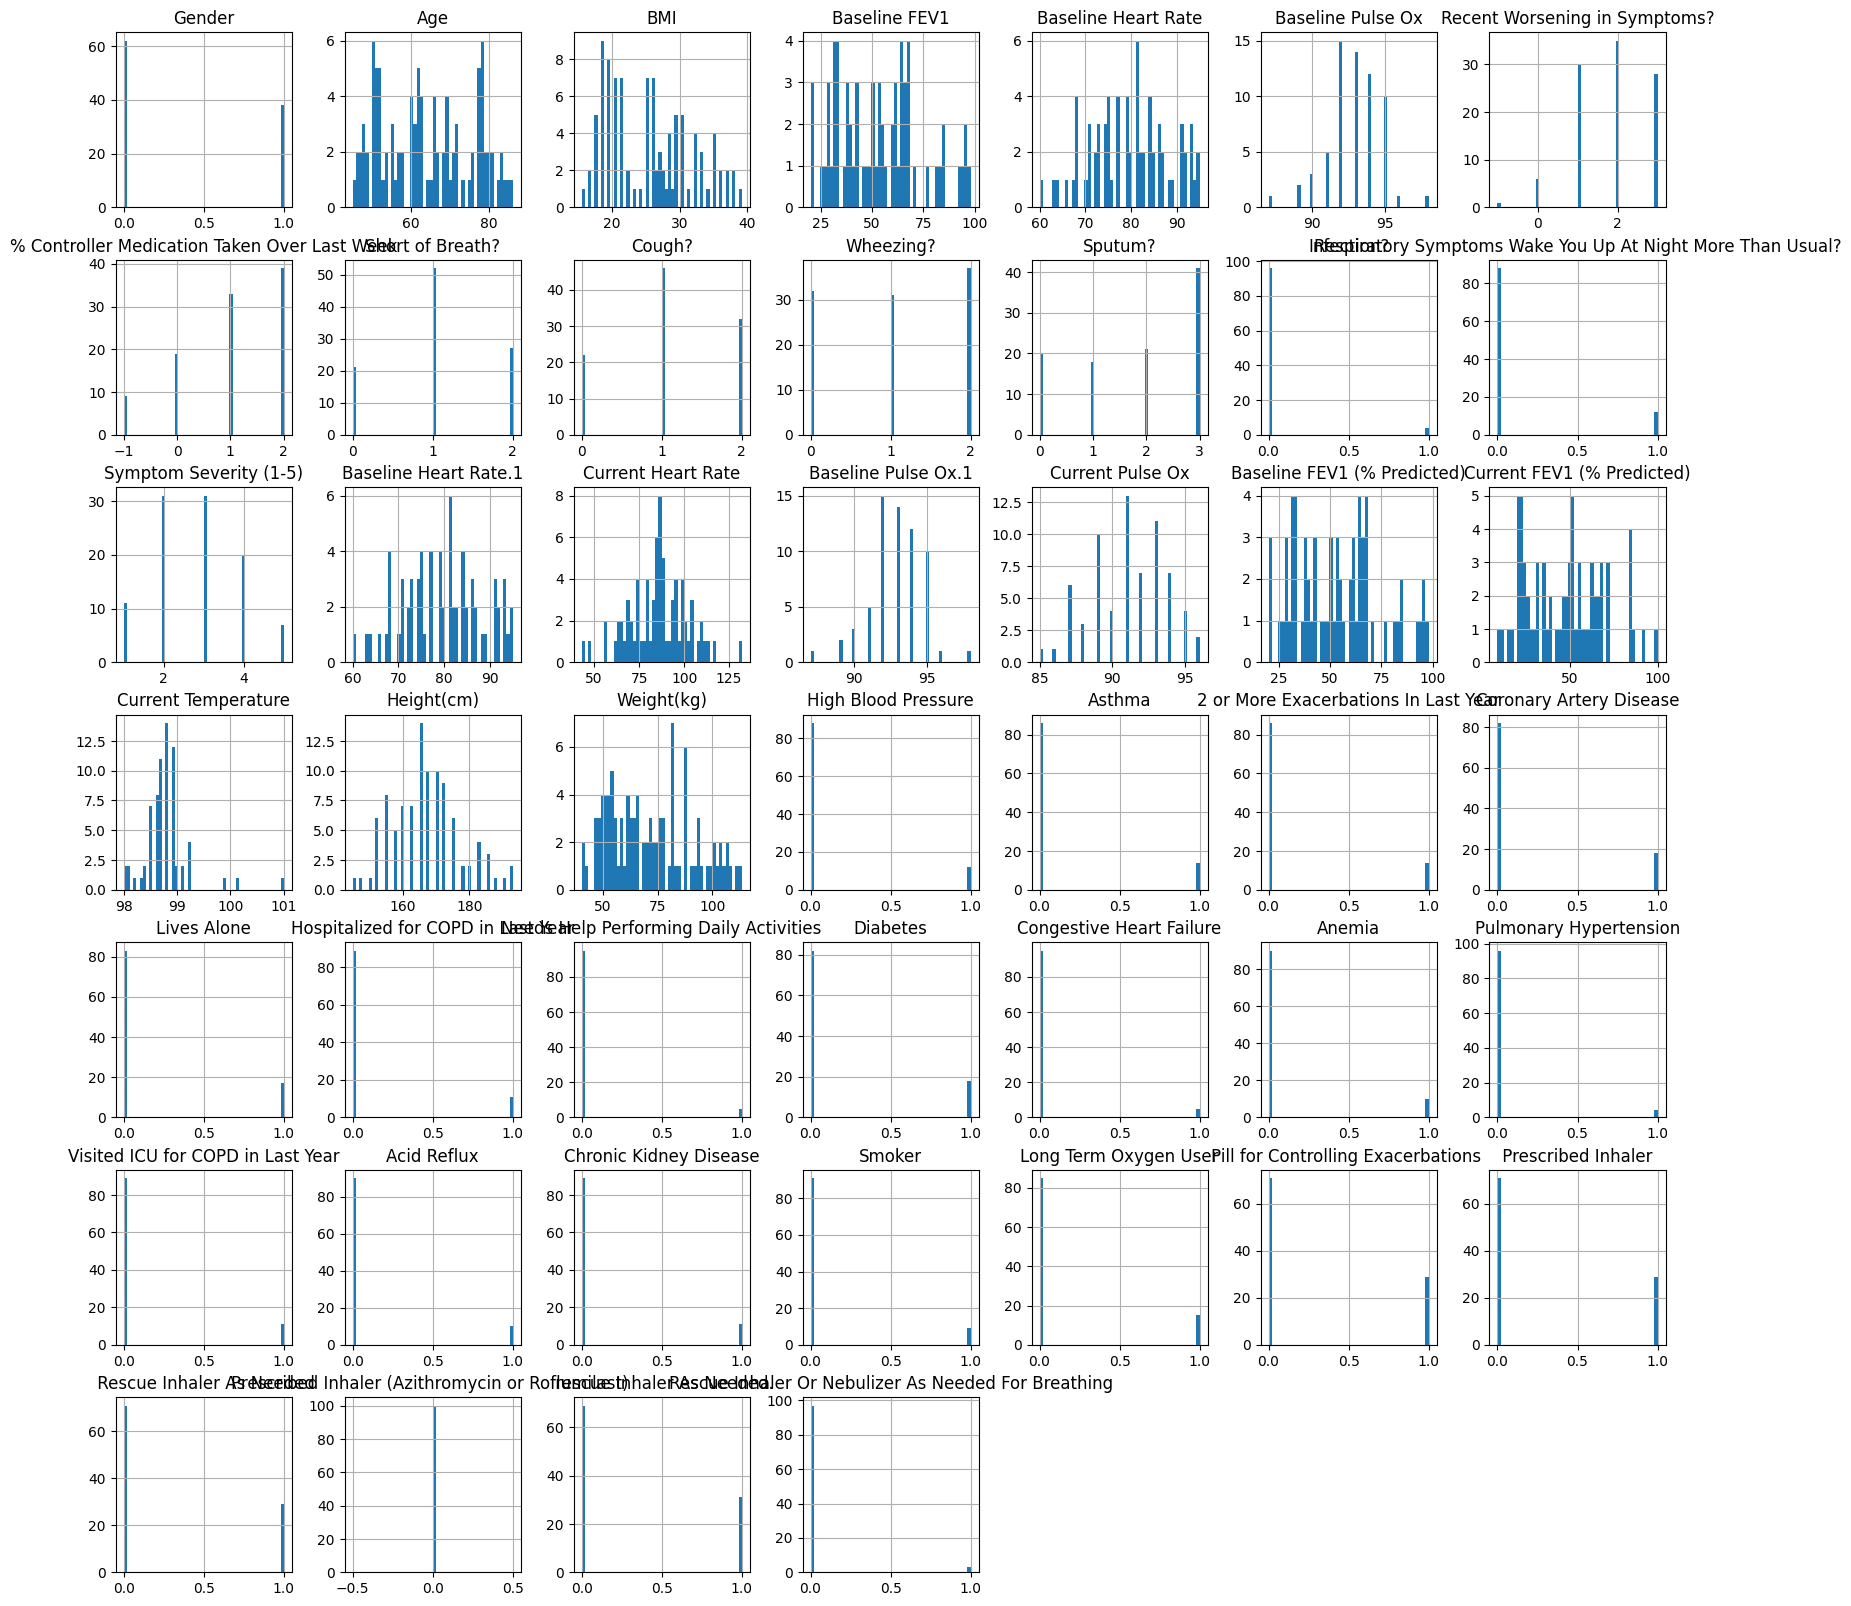

In [37]:
# plot histograms
triage.hist(bins=50, figsize=(20, 20))
# plot boxplots
# triage.plot(kind='box', subplots=True, layout=(5, 5), sharex=False, sharey=False, figsize=(20, 15))

# Classification

Accuracy: 0.7857142857142857


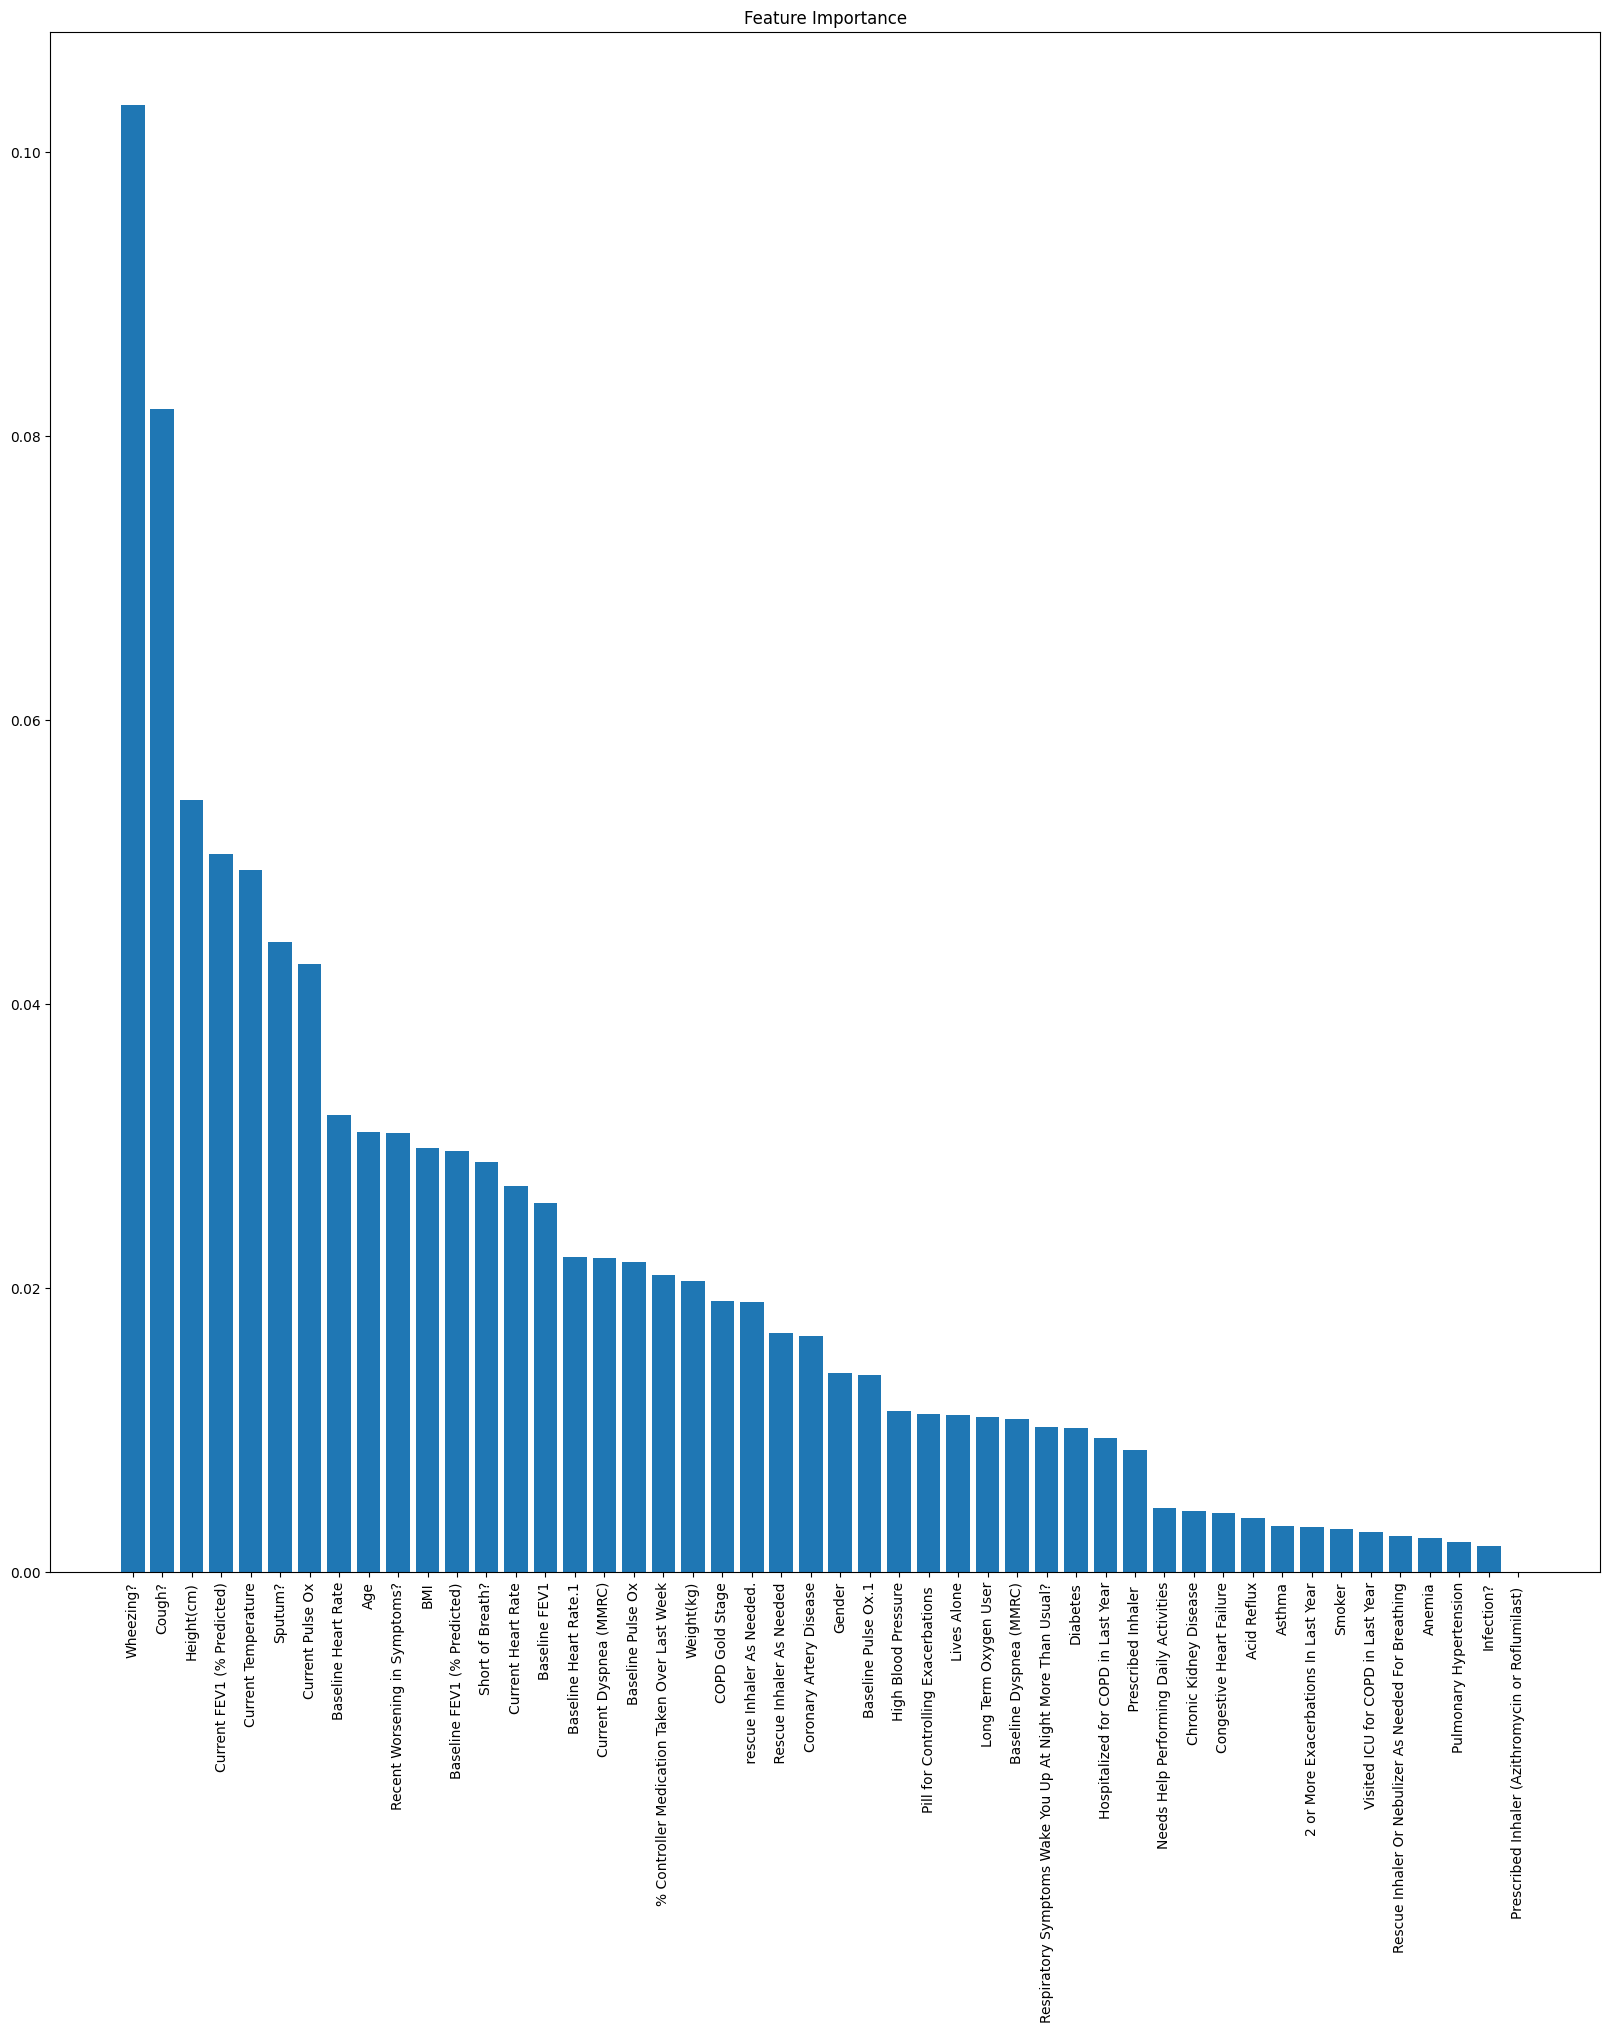

In [56]:
target = "Exacerbation (Y/N)"

# exclude variables from classification
triage = triage.drop(columns=["Symptom Severity (1-5)"])

X = triage.drop(columns=[target], axis=1)
y = triage[target]

# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
# models, predictions = clf.fit(X_train, X_test, y_train, y_test)
# models

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

# get variable importances
importances = clf.feature_importances_
# sort in descending order
indices = np.argsort(importances)[::-1]
# rearrange feature names so they match the sorted feature importances
names = [triage.columns[i] for i in indices]
# create plot
fig = plt.figure(figsize=(20,20))
plt.title("Feature Importance")
# add bars
plt.bar(range(X.shape[1]), importances[indices])
# add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90)
# show plot
plt.show()